In [38]:
#imports
from control import lqr
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

# Model based

## PID

In [ ]:
d = 2 # gap target (m)

#PI constants
Kp = 2
Ki = 0.5
Kd = 4

def System(t: float, x: np.ndarray, d_x_fwd: float):
    y = x[0]
    e = y - d #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = d_x_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = Kp*e + Ki*i_e + Kd*d_e 

    #dynamics:
    d_x1 = d_x_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

# LQR

In [46]:
d=2

# System dynamics (A, B matrices)
A = np.array([[0, -1, 0],
              [0,  0, 0],
              [1,  0, 0]])

B = np.array([[0], 
              [1], 
              [0]])

# Cost matrices
Q = np.diag([10, 1, 0.1])  # Penalize gap error, velocity error, and integral error
R = np.array([[0.1]])      # Penalize control effort

# Solve Riccati equation for LQR gain K
K, S, E = lqr(A, B, Q, R) # State feedback gains, Solution to Riccati equation, Eigenvalues of the closed loop system

print("LQR Gain (K):", K)

# Define system with LQR
def System(t: float, x: np.ndarray, d_x_fwd: float):
    y = x[0]
    e = y - d #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = d_x_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = float(-K @ x) #convert array to single value

    #dynamics:
    d_x1 = d_x_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

LQR Gain (K): [[-10.54281257   5.57544842  -1.        ]]


## Simulate

/tmp/ipykernel_3086/850793802.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x) #convert array to single value


[-1.         -0.81810581 -0.61033145 -0.38243142 -0.1395057   0.11396258
  0.37414085  0.63778954  0.90205666  1.16447072  1.42293662  1.67578917
  1.92171438  2.15959747  2.38851726  2.60773771  2.81665646  3.01507536
  3.20292011  3.38015524  3.54678405  3.70284865  3.84842992  3.98364237
  4.10873935  4.22421577  4.33055765  4.4282177   4.51761523  4.59913626
  4.67313343  4.73992602  4.7998      4.85303942  4.90013428  4.9415821
  4.97783522  5.00930952  5.03638454  5.0594034   5.0786728   5.09446309
  5.10700819  5.11650565  5.12311659  5.12702343  5.1285938   5.12807386
  5.12567883  5.1216074   5.11604174  5.10914749  5.10107374  5.0919531
  5.08190159  5.07101876  5.05938759  5.04707456  5.0341296   5.02058612
  5.00657286  4.9922699   4.97770617  4.96290879  4.9479043   4.93271858
  4.91737692  4.90190399  4.88632382  4.87065986  4.85493491  4.83917117
  4.82339021  4.80761301  4.7918599   4.77615062  4.76050426  4.74493934
  4.72947371  4.71412469  4.69895699  4.68399461  4.6

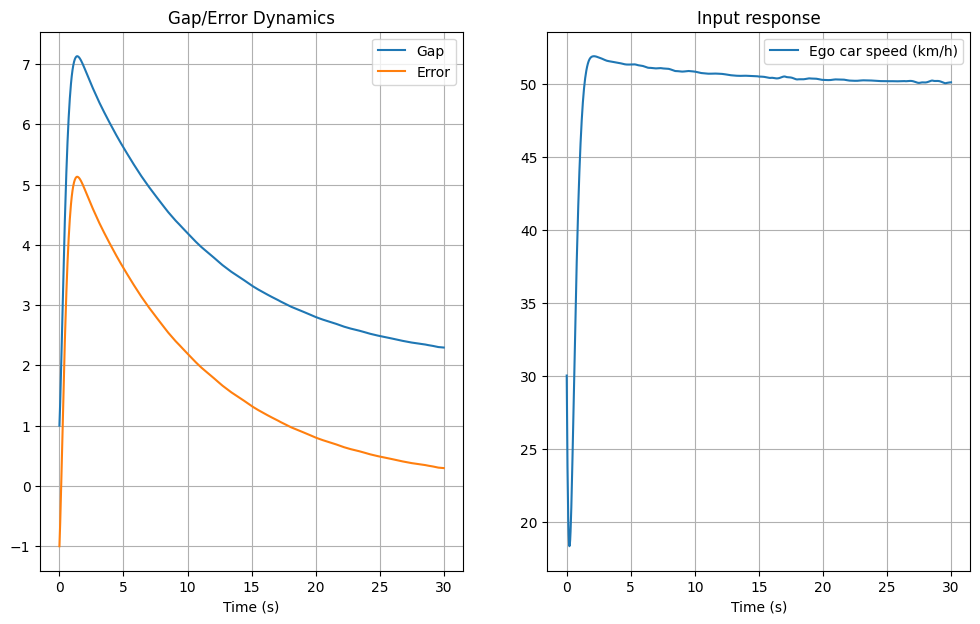

In [49]:
t_end = 30
t = np.linspace(0, t_end, 1000)
v_ego_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_ego_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 
u = 0 #car full stop
d_x_fwd = 50/3.6 # constant forward vehicle speed for now

x = integrate.solve_ivp(System, (0, t_end), x_0, t_eval=t, args=(d_x_fwd, )) #uses runge-kutta
gap, v_ego, I = x.y
y = gap
e = y - d
print(e)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(x.t, gap, label='Gap')
ax1.plot(x.t, e, label='Error')
ax1.set_xlabel('Time (s)')
ax1.set_title('Gap/Error Dynamics')
ax1.legend()
ax1.grid()

ax2.plot(x.t, v_ego*3.6, label = 'Ego car speed (km/h)')
ax2.set_xlabel('Time (s)')
ax2.set_title('Input response')
ax2.legend()
ax2.grid()

# Deep Learning/RL Based